In [8]:
import numpy as np

from sklearn import preprocessing
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import MinMaxScaler
from keras import backend as K
import cv2

import warnings
warnings.filterwarnings("ignore")

In [22]:
infile = open('Image_data.p','rb')
X_data = pickle.load(infile)

infile = open('Image_label.p','rb')
y_label = pickle.load(infile)

In [23]:
def convertTo1D(X):
    new_X = []
    for image in X:
        im = image.flatten()
        new_X.append(im)
    return new_X

def convertTo2D(X):
    new_X = []
    for image in X:
        im = np.reshape(image,(256,256))
        new_X.append(im)
    return new_X

def minmaxscaler(X,y):
    scaler = MinMaxScaler((0,1))
    X_flat = convertTo1D(X_data)
    y_flat = convertTo1D(y_label)
    
    norm_X = scaler.fit_transform(X_flat)
    norm_y = scaler.fit_transform(y_flat)
    
    new_X = convertTo2D(norm_X)
    new_y = convertTo2D(norm_y)
    
    return new_X,new_y

In [24]:
X_data,y_label = minmaxscaler(X_data,y_label)
X_data = np.asarray(X_data)
y_label = np.asarray(y_label)

In [54]:
def get_edge_detection_mask(input_images):
    output_images = []
    for img in input_images:
        img = img*255
        img = np.uint8(img)
        
        ret3,th3 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        edges = cv2.Canny(img,0,ret3*2)
        kernel = np.ones((3,3),np.uint8)
        dilation = (cv2.dilate(edges,kernel,iterations = 2))/255
        output_images.append(dilation)
    output_images = np.asarray(output_images)
    return output_images

In [26]:
def dice_score(pred, target):
    smooth = 1
    m1 = pred.flatten()  # Flatten
    m2 = target.flatten()  # Flatten
    intersection = (m1 * m2).sum()

    return (2 * intersection + smooth) / (m1.sum() + m2.sum() + smooth)

def iou_score(pred, target):
    smooth = 1
    m1 = pred.flatten()  # Flatten
    m2 = target.flatten()  # Flatten
    intersection = (m1 * m2).sum()

    return (intersection + smooth) / (m1.sum() + m2.sum() + smooth - intersection)

def sensitivity_score(pred, target):
    m1 = pred.flatten()
    m2 = target.flatten()
    target_neg = 1 - target
    pred_neg = 1 - pred
    fp = (target_neg*pred).sum()
    tn = (target_neg*pred_neg).sum()
    tp = (pred*target).sum()
    fn = (target*pred_neg).sum()
    S = tp/(tp+fn)
    return S

def specificity_score(pred, target):
    m1 = pred.flatten()
    m2 = target.flatten()
    target_neg = 1 - target
    pred_neg = 1 - pred
    fp = (target_neg*pred).sum()
    tn = (target_neg*pred_neg).sum()
    tp = (pred*target).sum()
    fn = (target*pred_neg).sum()
    S = tn/(tn+fp)
    return S


In [27]:
# function for metrics
def get_metrics(y_test_pred,test_label):
    val1 = 0
    val2 = 0
    val3 = 0
    val4 = 0
    for i in range(y_test_pred.shape[0]):
        val1 = val1 + dice_score(y_test_pred[i],test_label[i])
        val2 = val2 + iou_score(y_test_pred[i],test_label[i])
        val3 = val3 + sensitivity_score(y_test_pred[i],test_label[i])
        val4 = val4 + specificity_score(y_test_pred[i],test_label[i])

    dice_val = val1/y_test_pred.shape[0]
    iou_val = val2/y_test_pred.shape[0]
    sen_val = val3/y_test_pred.shape[0]
    spec_val = val4/y_test_pred.shape[0]

    print("dice score = ",round(dice_val,2))
    print("Iou score = ",round(iou_val,2))
    print("sensitivity score = ",round(sen_val,2))
    print("specificity score = ",round(spec_val,2))

In [55]:
# predincting masks 
pred_mask = get_edge_detection_mask(X_data)

In [56]:
get_metrics(pred_mask,y_label)

dice score =  0.71
Iou score =  0.57
sensitivity score =  0.87
specificity score =  0.91


In [58]:
def print_results(n):
    for i in range(n):
        plt.imshow(X_data[i])
        plt.title('original image')
        plt.show()
        plt.imshow(y_label[i])
        plt.title('ground truth mask')
        plt.show()
        plt.imshow(pred_mask[i])
        plt.title('predicted mask')
        plt.show()
        plt.imshow(y_label[i],cmap='gray')
        plt.imshow(pred_mask[i],cmap='jet',alpha=0.75)
        plt.title('overlay mask')
        plt.show()
        print('==========================================================')

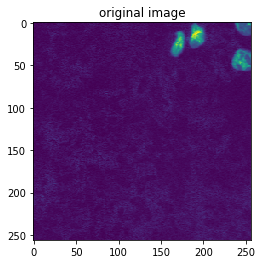

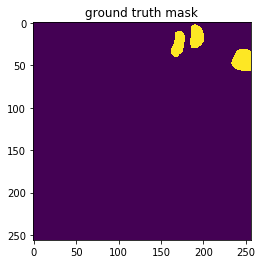

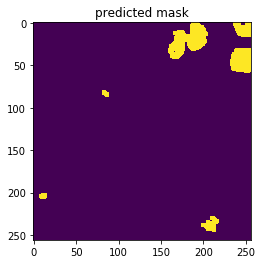

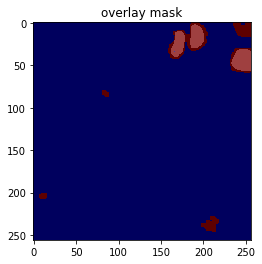

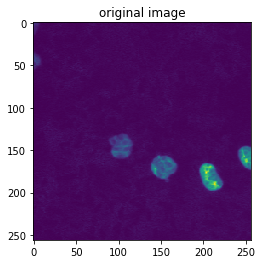

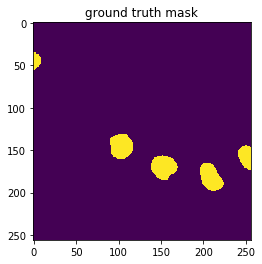

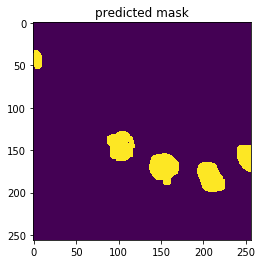

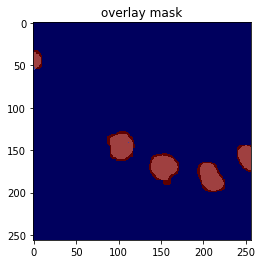

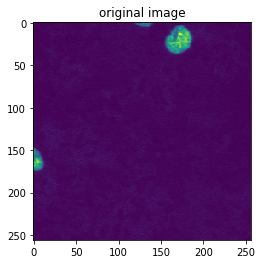

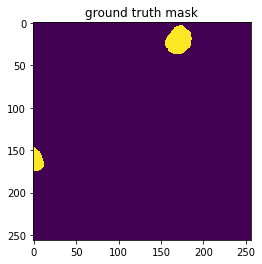

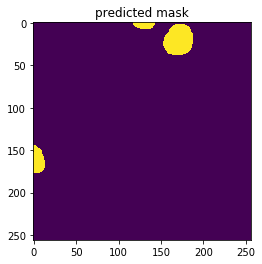

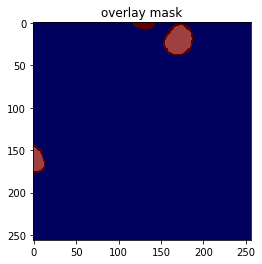

In [59]:
print_results(3)